In [1]:
### import yaml
import yaml
import pandas as pd
import numpy as np
from scipy.stats import t
from scipy.optimize import milp, LinearConstraint, Bounds
import matplotlib.pyplot as plt
# Load YML configuration file
with open("config_data1.yml", "r") as data:
    config = yaml.safe_load(data)

# Residential area load data
df = pd.read_excel('RESIDENTIAL_Load.xlsx', sheet_name='Sheet1', usecols='A:D', header=None) 
# Extract the total load data for Winter
Residential_TL_winter = df.iloc[:, 0].to_numpy() * 280  # Assuming column 0 contains total load data
# Extract the total load data for Spring
Residential_TL_spring = df.iloc[:, 1].to_numpy() * 280  
# Extract the total load data for summer
Residential_TL_summer = df.iloc[:, 2].to_numpy() * 280  
# Extract the total load data for fall
Residential_TL_fall = df.iloc[:, 3].to_numpy() * 280  
# Initialize the 96x12 matrix with zeros

Residential_TL = np.zeros((96, 12))

# Fill the matrix with the seasonal data
Residential_TL[:, 0:3] = Residential_TL_winter[:, np.newaxis]  # January to March
Residential_TL[:, 3:6] = Residential_TL_spring[:, np.newaxis]  # April to June
Residential_TL[:, 6:9] = Residential_TL_summer[:, np.newaxis]  # July to September
Residential_TL[:, 9:12] = Residential_TL_fall[:, np.newaxis]   # October to December

Residential_CL = Residential_TL * 0.3 

# Underground area load data
Underground_TL_df = pd.read_excel('UNDERGROUND_Load.xlsx', usecols="B:M", skiprows=147, nrows=96, header=None) 
Underground_CL_df = pd.read_excel('UNDERGROUND_Load.xlsx', usecols="B:M", skiprows=49, nrows=96, header=None)

Underground_TL = Underground_TL_df.to_numpy() 
Underground_CL = Underground_CL_df.to_numpy()

# Car Park area load data
EV1_df = pd.read_excel('EV_Data.xlsx', sheet_name='evcon', usecols='A:L', header=None) 
# Extract the EV1/EV2 consumption 
EV1_consumption = EV1_df.to_numpy() * 5 
EV2_consumption = EV1_consumption

# EV area critical load data 
EV_CL_df = pd.read_excel('EV_Data.xlsx', sheet_name='lc', usecols='A:L') 
EV_CL = EV_CL_df.to_numpy()  
EV_TL = (EV1_consumption + EV2_consumption + EV_CL) * 1.1

Dt = config['Dt']

# access storage systems parameters from YML file
# Underground bess data
V_DC_und = config['battery']['V_DC_und']
B_und = config['battery']['B_und']
C_und = config['battery']['C_und']
t = config['battery']['t']
P_max_und = config['battery']['P_max_und']
P_min_und = config['battery']['P_min_und']
in_SOC_und = config['battery']['in_SOC_und']
SOC_max_change_und = config['battery']['SOC_max_change_und']
P_max_und = 0.5 * P_max_und  # battery works at %40 of nominal power
in_SOC_und = 0.8
Pg_max_und = config['battery']['Pg_max_und']

# EV Parking bess data
V_DC_ev = config['battery']['V_DC_ev']
B_ev = config['battery']['B_ev']
C_ev = config['battery']['C_ev']
P_max_ev = config['battery']['P_max_ev']
P_min_ev = config['battery']['P_min_ev']
in_SOC_ev = config['battery']['in_SOC_ev']
SOC_max_change_ev = config['battery']['SOC_max_change_ev']
P_max_ev = 0.3 * P_max_ev  # battery works at %90 of nominal power
Pg_max_ev = config['battery']['Pg_max_ev']

# Residential bess data
V_DC_res = config['battery']['V_DC_res']
B_res = config['battery']['B_res']
C_res = config['battery']['C_res']
P_max_res = config['battery']['P_max_res']
P_min_res = config['battery']['P_min_res']
in_SOC_1_res = config['battery']['in_SOC_1_res']
in_SOC_2_res = config['battery']['in_SOC_2_res']
SOC_max_change_res = config['battery']['SOC_max_change_res']
P_max_res = P_max_res * 0.5
Pg_max_res = config['battery']['Pg_max_res']
in_SOC_1_res = 0.9
in_SOC_2_res = 0.6

# other bess parameters
Qch = config['battery']['Qch']
Qdis = config['battery']['Qdis']
SOC_max = config['battery']['SOC_max']
SOC_min = config['battery']['SOC_min']
D_SOC = config['battery']['D_SOC']
m_ch = config['battery']['m_ch']
m_dis = config['battery']['m_dis']
n = config['battery']['n']
n = 5
D_SOC = 0.8
# interlinking converters parametes

IC1 = config['interlinking_converters']['IC1']
IC2 = config['interlinking_converters']['IC2']
IC3 = config['interlinking_converters']['IC3']
P_IC_max = config['interlinking_converters']['P_IC_max']
Q_IC_max = config['interlinking_converters']['Q_IC_max']

# energy cost for 4 seasons
C_winter = config['C_winter']
C_spring = config['C_spring']
C_summer = config['C_summer']
C_fall = config['C_fall']

# objective function factors
f_grid = config['f_grid']
f_SOC = config['f_grid']

#grid parameters
S_base = config['S_base']

# RES PV/WIND POWER RATED PARAMETERS
C_PV_und = config['RES']['C_PV_und']
C_PV_ev = config['RES']['C_PV_ev']
C_PV_res = config['RES']['C_PV_res']
C_W_res = config['RES']['C_W_res']

In [2]:
def choose_grid():
  """Prompts the user to choose a grid and returns the corresponding number."""
  while True:
    try:
      grid_choice = int(input("Choose a grid:\n"
                               "0 - Underground Area\n"
                               "1 - Carpark Area\n"
                               "2 - Residential Area\n"
                               "3 - User's network\n"
                               "Enter your choice (0, 1, 2, or 3): "))
      if grid_choice not in (0, 1, 2, 3):
        print("Invalid choice. Please enter 0, 1, 2, or 3.")
      else:
        return grid_choice
    except ValueError:
      print("Invalid input. Please enter a number (0, 1, 2, or 3).")

grid_number = choose_grid()

while True:
        try:
            month = int(input("Enter a month (1-12): "))
            if month < 1 or month > 12:
               raise ValueError
            break
        except ValueError:
            print("Invalid input. Please enter a valid month (1-12).")

  # Determine maximum valid day based on chosen month
max_day = {
      1: 31,
      2: 28,  # Adjust for leap years later (optional)
      3: 31,
      4: 30,
      5: 31,
      6: 30,
      7: 31,
      8: 31,
      9: 30,
      10: 31,
      11: 30,
      12: 31
  }[month]  # Use a dictionary for efficient lookup

  # User input for day (within month's range)
while True:
      try:
        day = int(input(f"Enter a day (1-{max_day}): "))
        if day < 1 or day > max_day:
          raise ValueError
        break
      except ValueError:
        print(f"Invalid input. Please enter a day between 1 and {max_day}.")

Choose a grid:
0 - Underground Area
1 - Carpark Area
2 - Residential Area
3 - User's network
Enter your choice (0, 1, 2, or 3):  2
Enter a month (1-12):  2
Enter a day (1-28):  25


In [3]:
import datetime
import matplotlib.pyplot as plt

# Function to filter the data to keep only the last 'n' years
def filter_last_n_years(data, n):
    # Convert 'time' to datetime format
    data['time'] = pd.to_datetime(data['time'], format='%Y%m%d:%H%M')
    # Get the maximum year in the data
    max_year = data['time'].dt.year.max()
    # Filter for the last 'n' years
    filtered_data = data[data['time'].dt.year >= max_year - n + 1]
    # Remove February 29th (leap year days)
    filtered_data = filtered_data[~((filtered_data['time'].dt.month == 2) & (filtered_data['time'].dt.day == 29))] 
    return filtered_data


def stack_x(x, n_y, n_hours=8760):
    """
    Reshapes a 1D time series vector into a 2D pandas DataFrame.

    Parameters:
    x (array-like): The input time series vector (length should be n_y * n_hours).
    n_y (int): The number of years (rows in the resulting DataFrame).
    n_hours (int): The number of hours per year (default is 8760).

    Returns:
    pd.DataFrame: A DataFrame where each row corresponds to a year's worth of data. 

    Raises:
    ValueError: If the length of x is not sufficient for the specified number of years. 
    """
    # Check if the input series length is sufficient
    total_length = n_y * n_hours
    if len(x) != total_length:
        raise ValueError(f"The input data 'x' must have exactly {total_length} elements for {n_y} years.") 
    # Reshape the data into a 2D array with n_y rows and n_hours columns
    reshaped_data = np.array(x).reshape(n_y, n_hours)
    # Convert the reshaped array to a DataFrame
    return pd.DataFrame(reshaped_data)


def get_block_nbb(x, r1, r2, l): 
    """
    Extracts a block of consecutive observations from a specific year in the stacked DataFrame. # noqa

    Parameters:
    x (pd.DataFrame): The stacked DataFrame containing time series data.
    r1 (int): The starting observation index (0 to 8759).
    r2 (int): The specific year (0 to n_y-1).
    l (int): The width of the block to extract

    Returns:
    pd.Series: A Series containing the extracted observations.

    """
    # Extract the block of observations
    return x.iloc[r2, r1:r1 + l]


def local_nbb(x, l, ll, B, day, month): 
    # Assuming n_y is derived from the length of x
    n_y = len(x) // 8760
    # Create the stacked DataFrame
    stacked_x = stack_x(x=x, n_y=n_y)
    stacked_x_circ = pd.concat([stacked_x, stacked_x.iloc[:, :l]], axis=1)
    # Create circular days array
    id_days = np.arange(1, 8761, l)
    id_days_c = np.concatenate((id_days[-ll:], id_days, id_days[:ll]))
    # Initialize the result matrix with NaNs
    res = np.full((24, B), np.nan)
    yday = datetime.date(2017, month, day).timetuple().tm_yday
    i = yday - 1
    # Start bootstrapping
    for j in range(B):
        boot = []
        r1 = np.random.choice(range(i, 2 * ll + i + 1), size=1)[0]
        r2 = np.random.choice(range(n_y), size=1)[0]  # Sample for r2
        # Get the block of data using your previously defined function
        block_data = get_block_nbb(stacked_x_circ, r1=id_days_c[r1], r2=r2, l=l) 
        boot.extend(block_data)  # Append to the boot list
        res[:, j] = boot[:24]
    # Convert the result to a DataFrame
    return pd.DataFrame(res)


def add_time_column(boot_matrix):
    # Create a non-leap year datetime index (8760 hours)
    time_index = pd.date_range(start='2023-01-01', end='2023-12-31 23:00', freq='h')
    # Add the time column to the DataFrame
    boot_matrix['time'] = time_index
    return boot_matrix


def wind_to_power(w, pwr=33, wi=1.5, wr=3.5, wo=5):
        if w < wi or w > wo:
            P_wind = 0
        elif wi <= w <= wr:
            P_wind = pwr * ((w - wi) / (wr - wi))
        else:
            P_wind = pwr
        return P_wind

    # function to convert solar into power

# underground = 109, car park = 20, residential = 33
def solar_to_power(I, T, power_rated=50):
    return (power_rated * I) / (1000 * (1 + 0.003 * (T - 25)))


def get_perc_col(df, perc):
    # Step 1: Compute the mean for each column
    means = df.mean(axis=0)
    # Step 2: Sort the column means
    sorted_means = means.sort_values()
    # Step 3: Compute the index for the desired percentile
    p_index = round(len(sorted_means) * perc) - 1  # Use 0-based index
    # Step 4: Get the column corresponding to the percentile index
    closest_column_name = sorted_means.index[p_index]
    return df[closest_column_name]


# Function to process the dataframe and calculate wind and solar power
def compute_power_from_df(df, power_rated=50):
    # Apply wind_to_power to the 'wind' column
    wind_power = df.iloc[:, 1].apply(wind_to_power).to_list()

    # Compute solar power for each row using list comprehension
    solar_power = [solar_to_power(I, T, power_rated) for I, T in zip(df.iloc[:, 2], df.iloc[:, 0])]
    
    # Create new dataframe with wind and solar power
    power_df = pd.DataFrame({
        'wind_power': wind_power,
        'solar_power': solar_power
    })
    
    return power_df

def plot_scenarios(dfs, titles, y_limit=60):
    # Define colors and line styles for wind and solar lines
    wind_color = 'b'
    solar_color = 'g'
    wind_linestyle = '-'
    solar_linestyle = '--'

    # Determine the number of scenarios
    num_scenarios = len(dfs)
    rows = (num_scenarios + 1) // 2  # Calculate number of rows needed (2 columns)

    # Create a figure and axes for subplots
    fig, axes = plt.subplots(nrows=rows, ncols=2, figsize=(8, 4 * rows))

    # Flatten the axes array for easy iteration
    axes = axes.flatten()

    # Iterate through the list of dataframes and their corresponding titles
    for i, (ax, df, title) in enumerate(zip(axes, dfs, titles)):
        # Plot the wind_power (1st column) and solar_power (2nd column)
        ax.plot(df['wind_power'], label='Wind Power', color=wind_color, linestyle=wind_linestyle)
        ax.plot(df['solar_power'], label='Solar Power', color=solar_color, linestyle=solar_linestyle)

        # Customize the plot
        ax.set_title(title.replace("-", "").replace("pw", "").capitalize())
        ax.set_ylabel('Power Output [kW]')
        ax.set_xlabel('Time interval')
        ax.set_ylim(0, y_limit)  # Set y-axis limits
        ax.legend()
        ax.grid(True)

        # Hide any unused subplots
        if i >= num_scenarios:
            ax.axis('off')

    # Adjust layout and show the figure in a single window
    plt.tight_layout()
    plt.show()


# Read the Excel file
dati = pd.read_excel("D:\Postdoc Unipa\ENEA Project\OPF\python codes\Andrea_data/Dati Palermo.xlsx") # noqa

# Rename the columns
dati.columns = ["time", "solar_radiation", "temperature", "wind_speed"]
# Pick the last 4 years
n_y = 5
filtered_dati = filter_last_n_years(dati, n_y)

#dec_wind = decompose_series(filtered_dati, 'wind_speed')
# plot_trend_and_seasonality(dec_wind)

l = 24
ll = 10
B = 50
# day and month
month = month
day = day

# power rated selection for solar system
if grid_number == 0:
    power_rated = C_PV_und
elif grid_number == 1:
    power_rated = C_PV_ev
elif grid_number == 2:
    power_rated = C_PV_res
else:
    while True:
        try:
            power_rated = float(input("Enter the power rating: "))
            break
        except ValueError:
            print("Invalid input. Please enter a number.")

boot_wind = local_nbb(x=filtered_dati['wind_speed'], l=l, ll=ll, B=B, day=day, month=month)
#plot_bootstrap_results(boot)
boot_solar = local_nbb(x=filtered_dati['solar_radiation'], l=l, ll=ll, B=B, day=day, month=month)
#plot_bootstrap_results(boot_solar)
boot_temp = local_nbb(x=filtered_dati['temperature'], l=l, ll=ll, B=B, day=day, month=month)
#plot_bootstrap_results(boot_temp)

avg_temp = boot_temp.mean(axis=1)
avg_wind = boot_wind.mean(axis=1)
avg_solar = boot_solar.mean(axis=1)

high_temp = get_perc_col(boot_temp, 0.95)
high_wind = get_perc_col(boot_wind, 0.95)
low_wind = get_perc_col(boot_wind, 0.05)
low_solar = get_perc_col(boot_solar, 0.05)

# 5 scenarios
# Mean scenario
mean_scenario = pd.DataFrame({
    'avg_temp': avg_temp,
    'avg_wind': avg_wind,
    'avg_solar': avg_solar
})

# High temp scenario
high_temp_scenario = pd.DataFrame({
    'high_temp': high_temp,
    'avg_wind': avg_wind,
    'avg_solar': avg_solar
})

# High wind scenario
high_wind_scenario = pd.DataFrame({
    'avg_temp': avg_temp,
    'high_wind': high_wind,
    'avg_solar': avg_solar
})

# Low wind scenario
low_wind_scenario = pd.DataFrame({
    'avg_temp': avg_temp,
    'low_wind': low_wind,
    'avg_solar': avg_solar
})

# Low solar scenario
low_solar_scenario = pd.DataFrame({
    'avg_temp': avg_temp,
    'avg_wind': avg_wind,
    'low_solar': low_solar
})

# power calculations for 5 scenarios
mean_scenario_pw = compute_power_from_df(mean_scenario, power_rated=power_rated)
high_temp_scenario_pw = compute_power_from_df(high_temp_scenario, power_rated=power_rated)
low_solar_scenario_pw = compute_power_from_df(low_solar_scenario, power_rated=power_rated)
high_wind_scenario_pw = compute_power_from_df(high_wind_scenario, power_rated=power_rated)
low_wind_scenario_pw = compute_power_from_df(low_wind_scenario, power_rated=power_rated)

# plot the results
dfs = [mean_scenario_pw, high_temp_scenario_pw, low_solar_scenario_pw, high_wind_scenario_pw, low_wind_scenario_pw]
titles = ['mean_scenario_pw', 'high_temp_scenario_pw', 'low_solar_scenario_pw', 'high_wind_scenario_pw', 'low_wind_scenario_pw']

# Call the function
# plot_scenarios(dfs, titles)

# to make 96 rows
mean_scenario_pw_repeated = np.repeat(mean_scenario_pw, 4, axis=0)
high_temp_scenario_pw_repeated = np.repeat(high_temp_scenario_pw, 4, axis=0)
low_solar_scenario_pw_repeated = np.repeat(low_solar_scenario_pw, 4, axis=0)
high_wind_scenario_pw_repeated = np.repeat(high_wind_scenario_pw, 4, axis=0)
low_wind_scenario_pw_repeated = np.repeat(low_wind_scenario_pw, 4, axis=0)

# seperate wind power and PV power
mean_scenario_pv = mean_scenario_pw_repeated[:, 1]
mean_scenario_wt = mean_scenario_pw_repeated[:, 0]

high_temp_scenario_pv = high_temp_scenario_pw_repeated[:, 1]
high_temp_scenario_wt = high_temp_scenario_pw_repeated[:, 0]

low_solar_scenario_pv = low_solar_scenario_pw_repeated[:, 1]
low_solar_scenario_wt = low_solar_scenario_pw_repeated[:, 0]

high_wind_scenario_pv = high_wind_scenario_pw_repeated[:, 1]
high_wind_scenario_wt = high_wind_scenario_pw_repeated[:, 0]

low_wind_scenario_pv = low_wind_scenario_pw_repeated[:, 1]
low_wind_scenario_wt = low_wind_scenario_pw_repeated[:, 0]

# make different data frames for different networks
df_und = [mean_scenario_pv, high_temp_scenario_pv, low_solar_scenario_pv]
df_ev = [mean_scenario_pv, high_temp_scenario_pv, low_solar_scenario_pv]
df_res = [mean_scenario_pv+mean_scenario_wt, high_temp_scenario_pv+high_temp_scenario_wt,
         low_solar_scenario_pv+low_solar_scenario_wt, high_wind_scenario_pv+high_wind_scenario_wt,
         low_wind_scenario_pv+low_wind_scenario_wt]

label_und = ["mean scenario", "high temp scenario", "low solar scenario"]
label_ev = ["mean scenario", "high temp scenario", "low solar scenario"]
label_res = ["mean scenario", "high temp scenario", "low solar scenario", "high wind scenario",
             "low wind scenario"]

# Optimization codes

You selected the Residential Area.
0
[51.2133  33.75    33.75     0.       0.       0.86875  0.56875  1.
  0.       1.      -0.     ]
1
[80.90441509 33.75        4.05888491  0.          0.          0.8375
  0.56499177  1.          0.          1.          0.        ]
2
[74.64744634 33.75        4.71585366  0.          0.          0.80625
  0.56062524  1.          0.          1.          0.        ]
3
[68.2768885  33.75        5.4864115   0.          0.          0.775
  0.55554523  1.          0.          1.          0.        ]
4
[55.8453371  33.75        6.3879629   0.          0.          0.74375
  0.54963045  1.          0.          1.          0.        ]
5
[43.59467248 33.75        7.43862752  0.          0.          0.7125
  0.54274283  1.          0.          1.          0.        ]
6
[36.77724675 33.75        8.65605325  0.          0.          0.68125
  0.53472797  1.          0.          1.          0.        ]
7
[29.77775295 33.75       10.05554705  0.          0.          0.

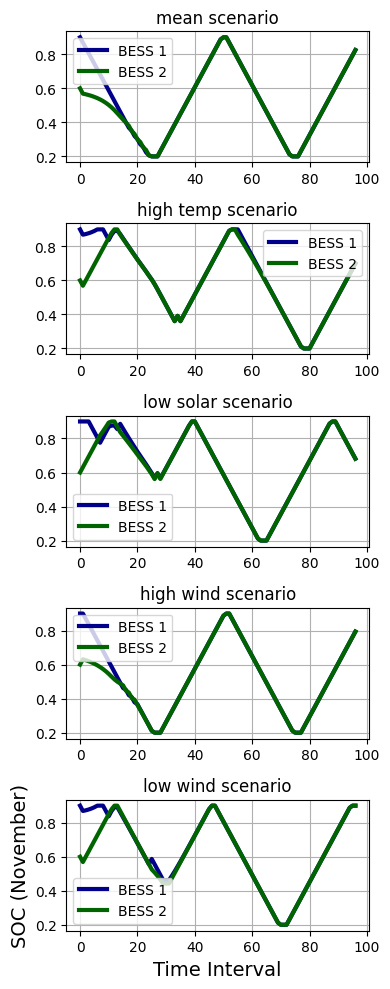

In [4]:
if grid_number == 0:
  print("You selected the Underground Area.")
# Access corresponding load and PV power values
  load = Underground_TL[:, month - 1] 
  load_c = Underground_CL[:, month - 1]
  ### choose the bound for PV power output
  soc_scenarios = []
  # initial matrices for Underground area variables 
  p_g = np.zeros((96,1))
  p_dis = np.zeros((96, 1))
  p_ch = np.zeros((96, 1))
  SOC = np.zeros((96, 1))
  I_dis = np.zeros((96, 1))
  I_ch = np.zeros((96, 1))
  
  K = 0.5
  landa_b = np.zeros((96,1))
  landa_b[0, 0] = K * SOC_max / in_SOC_und
  landa_g = 1 / Pg_max_und   # 1500 is the power rated of the network

  for scenario in df_und:
       pv_power = scenario
       complete_SOC = np.array([in_SOC_und])
       for j in range(96):
           if j == 0:
               c = np.array([landa_g,0,0,-landa_b[j, 0],0,0])  
           else:
               c = np.array([landa_g,0,0,-landa_b[j-1, 0],0,0]) 
           
           integrality = ([0,0,0,0,1,1])  # last two variables are binary variables      

           # load supply constraint
           A0 = [1,1,-1,0,0,0]
           l0 = u0 = load[j] - pv_power[j]
           # SoC constraints
           if j == 0:
               A1 = [0,(Qdis * Dt * 1000) / (V_DC_und * C_und),-(Dt * 1000) / (V_DC_und * C_und * Qch),1,0,0]
               l1 = u1 = in_SOC_und
           else:
               A1 = [0,(Qdis * Dt * 1000) / (V_DC_und * C_und),-(Dt * 1000) / (V_DC_und * C_und * Qch),1,0,0]
               l1 = u1 = SOC[j - 1, 0]
     
           A2 = [0,1,0,0,-1 * P_max_und,0]    # discharging constraint for battery 
           l2 = -P_max_und + P_min_und
           u2 = 0
     
           A3 = [0,-1,0,0,1 * P_min_und,0]    # discharging constraint for battery 
           l3 = -P_max_und + P_min_und
           u3 = 0
      
           A4 = [0,0,1,0,0,-1 * P_max_und]    # charging constraint for battery 
           l4 = -P_max_und + P_min_und
           u4 = 0

           A5 = [0,0,-1,0,0,1 * P_min_und]    # charging constraint for battery 
           l5 = -P_max_und + P_min_und
           u5 = 0

           A6 = [0,0,0,0,1,1]    # binary variables constraint for battery 
           l6 = 0
           u6 = 1

           #A7 = [0,0,0,1,0,0]    # charging constraint for battery 
           #l7 = SOC_min + (3 * 1000 * load_c[j] * Dt * Qdis) / (V_DC_und * C_und)
           #u7 = SOC_max

           A = np.array([A0,A1,A2,A3,A4,A5,A6])
           l = np.array([l0,l1,l2,l3,l4,l5,l6])
           u = np.array([u0,u1,u2,u3,u4,u5,u6])

           # New constraint: SOC difference limit at the last time step
           if j == 95:
               A8 = [0, 0, 0, 1, 0, 0]
               l8 = in_SOC_und - D_SOC # Lower bound for SOC difference
               u8 = in_SOC_und + D_SOC    # Upper bound for SOC difference
               A = np.vstack((A, A8))
               l = np.append(l, l8)
               u = np.append(u, u8)
          
           if j > 0:
               A9 = [0, 0, 0, 1, 0, 0]  # No changes to the first 6 variables
               l9 = SOC[j-1, 0] - SOC_max_change_und
               u9 = SOC[j-1, 0] + SOC_max_change_und
               A = np.vstack((A, A9))
               l = np.append(l, l9)
               u = np.append(u, u9)
      ## BOUNDS
           l_b = [0, P_min_und, P_min_und, SOC_min, 0, 0]
           u_b = [Pg_max_und, P_max_und, P_max_und, SOC_max, 1, 1]
      
           result = milp(c, integrality = integrality, bounds=Bounds(l_b, u_b), 
                         constraints = LinearConstraint(A, l, u))
                       
           # result of optimization variables
           print(j)
           print (result.x)  
           p_g[j, 0] = result.x[0]   # power imported from the grid
           p_dis[j, 0] = result.x[1] # discharge power of the battery
           p_ch[j, 0] = result.x[2]  # charge power of the battery
           SOC[j, 0] = result.x[3]   # state of charge of the battery
           I_dis[j, 0] = result.x[4] # binary variables for dischrage state
           I_ch[j, 0] = result.x[5]  # binary variables for charge state
           
           complete_SOC = np.append(complete_SOC, SOC[j, 0])
           landa_b[j, 0] = K * SOC_max / SOC[j, 0]

      # New logic to check SOC difference and calculate 'r' and 'K'
           if j > 0:
               if SOC[j, 0] - SOC[j-1, 0] >= 0:
                   K = K + 0.08  # Calculate new 'K'         
               if SOC[j, 0] == SOC_max:
                   K = 0.5
                   
       soc_scenarios.append(complete_SOC.flatten())
  # Plot SoC
  plt.figure(figsize=(5, 2))
  
  plt.grid(True)
  plt.plot(soc_scenarios[0], label='Mean Scenario', color='darkgreen', linewidth=3)
  plt.plot(soc_scenarios[1], label='High Temp Scenario', color='#800080', linewidth=3)
  plt.plot(soc_scenarios[2], label='Low Solar Scenario', color='darkblue', linewidth=3)
    
  plt.xlabel('Time Interval', fontsize=14)
  plt.ylabel('SOC (November)', fontsize=14)
  plt.legend(bbox_to_anchor=(0.5, 1.05), loc='center', borderaxespad=0.)
    
  plt.savefig('und_Nov.png', dpi=1500)
  plt.show()
  
elif grid_number == 1:
  # Code for carpark area
  print("You selected the Carpark Area.")
  load = EV_TL[:, month - 1] 
  load_c = EV_CL[:, month - 1]    
  soc_scenarios = []
  
  p_g = np.zeros((96,1))
  p_dis = np.zeros((96, 1))
  p_ch = np.zeros((96, 1))
  SOC = np.zeros((96, 1))
  I_dis = np.zeros((96, 1))
  I_ch= np.zeros((96, 1))
  
  K = 0.5
  landa_b = np.zeros((96,1))
  landa_b[0, 0] = K * SOC_max / in_SOC_ev
  landa_g = 1 / Pg_max_ev   

  for scenario in df_ev:
      pv_power = scenario
      complete_SOC = np.array([in_SOC_ev])
      for j in range(96):
          if j == 0:
              c = np.array([landa_g,0,0,-landa_b[j, 0],0,0])  
          else:
               c = np.array([landa_g,0,0,-landa_b[j-1, 0],0,0]) 
         
          integrality = ([0,0,0,0,1,1])  # last four variables are binary variables
    
          # load supply constraint
          A0 = [1,1,-1,0,0,0]
          l0 = u0 = load[j] - (pv_power[j])

          # SoC constraints
          if j == 0:
               A1 = [0,(Qdis * Dt * 1000) / (V_DC_ev * C_ev),-(Dt * 1000) / (V_DC_ev * C_ev * Qch),1,0,0]
               l1 = u1 = in_SOC_ev                  
          else:
              A1 = [0,(Qdis * Dt * 1000) / (V_DC_ev * C_ev),-(Dt * 1000) / (V_DC_ev * C_ev * Qch),1,0,0]
              l1 = u1 = SOC[j - 1, 0]
    
          A2 = [0,1,0,0,-1 * P_max_ev,0]    # discharging constraint for battery 1
          l2 = -P_max_ev + P_min_ev
          u2 = 0

          A3 = [0,-1,0,0,1 * P_min_ev,0]    # discharging constraint for battery 1
          l3 = -P_max_ev + P_min_ev
          u3 = 0

          A4 = [0,0,1,0,0,-1 * P_max_ev]    # charging constraint for battery 1
          l4 = -P_max_ev + P_min_ev
          u4 = 0

          A5 = [0,0,-1,0,0,1 * P_min_ev]    # charging constraint for battery 1
          l5 = -P_max_ev + P_min_ev
          u5 = 0

          A6 = [0,0,0,0,1,1]    # binary variables constraint for battery 1
          l6 = 0
          u6 = 1

          #A7 = [0,0,0,1,0,0]    # charging constraint for battery 
          #l7 = SOC_min + (3 * 1000 * load_c[j] * Dt * Qdis) / (V_DC_ev * C_ev)
          #u7 = SOC_max

          A = np.array([A0,A1,A2,A3,A4,A5,A6])
          l = np.array([l0,l1,l2,l3,l4,l5,l6])
          u = np.array([u0,u1,u2,u3,u4,u5,u6])

          if j == 95:
              A8 = [0, 0, 0, 1, 0, 0]
              l8 = in_SOC_ev - D_SOC # Lower bound for SOC difference
              u8 = in_SOC_ev + D_SOC    # Upper bound for SOC difference
              A = np.vstack((A, A8))
              l = np.append(l, l8)
              u = np.append(u, u8)
          
          if j > 0:
              A9 = [0, 0, 0, 1, 0, 0]  # No changes to the first 6 variables
              l9 = SOC[j-1, 0] - SOC_max_change_ev
              u9 = SOC[j-1, 0] + SOC_max_change_ev
              A = np.vstack((A, A9))
              l = np.append(l, l9)
              u = np.append(u, u9)
  
          l_b = [0, P_min_ev, P_min_ev, SOC_min, 0, 0]
          u_b = [50, P_max_ev, P_max_ev, SOC_max, 1, 1]
                    
          result = milp(c, integrality = integrality, bounds=Bounds(l_b, u_b), 
                        constraints = LinearConstraint(A, l, u))
                  
          print(j)
          print (result.x)  
          p_g[j, 0] = result.x[0]
          p_dis[j, 0] = result.x[1]
          p_ch[j, 0] = result.x[2]
          SOC[j, 0] = result.x[3]
          I_dis[j, 0] = result.x[4]
          I_ch[j, 0] = result.x[5]
          complete_SOC = np.append(complete_SOC, SOC[j, 0])
          landa_b[j, 0] = K * SOC_max / SOC[j, 0]

          if j > 0:
               if SOC[j, 0] - SOC[j-1, 0] >= 0:
                   K = K + 0.4  # Calculate new 'K'                    
               if SOC[j, 0] == SOC_max:
                   K = 0.5         

      soc_scenarios.append(complete_SOC.flatten())
  # Plot SoC
  plt.figure(figsize=(5, 2))
  plt.grid(True)
  plt.plot(soc_scenarios[0], label='Mean Scenario', color='darkgreen', linewidth=3)
  plt.plot(soc_scenarios[1], label='High Temp Scenario', color='#800080', linewidth=3)
  plt.plot(soc_scenarios[2], label='Low Solar Scenario', color='darkblue', linewidth=3)
  plt.xlabel('Time Interval', fontsize=14)
  plt.ylabel('SOC (November)', fontsize=14)
  plt.legend(bbox_to_anchor=(0.5, 1.05), loc='center', borderaxespad=0.)
  plt.savefig('ev_Nov.png', dpi=1500)
  plt.show()

elif grid_number == 2:
  # Code for residential area
  print("You selected the Residential Area.")
  load = Residential_TL[:, month - 1] 
  load_c = Residential_CL[:, month - 1]
  soc_scenarios = []
 
  p_g = np.zeros((96, 1))
  p_dis_1 = np.zeros((96, 1))
  p_dis_2 = np.zeros((96, 1))
  p_ch_1 = np.zeros((96, 1))
  p_ch_2 = np.zeros((96, 1))
  SOC_1 = np.zeros((96, 1))
  SOC_2 = np.zeros((96, 1))
  I_dis_1 = np.zeros((96, 1))
  I_ch_1 = np.zeros((96, 1))
  I_dis_2 = np.zeros((96, 1))
  I_ch_2 = np.zeros((96, 1))

  K1 = 0.5
  K2 = 0.5
  landa_b1 = np.zeros((96,1))
  landa_b2 = np.zeros((96,1))
  landa_b1[0, 0] = K1 * SOC_max / in_SOC_1_res
  landa_b2[0, 0] = K2 * SOC_max / in_SOC_2_res
  landa_g = 1 / Pg_max_res   

  for scenario in df_res:
      Ren_power = scenario
      complete_SOC1 = np.array([in_SOC_1_res])
      complete_SOC2 = np.array([in_SOC_2_res])  
      for j in range(96):
          if j == 0:
              c = np.array([landa_g,0,0,0,0,-landa_b1[j, 0],-landa_b2[j, 0],0,0,0,0])   
          else:
              c = np.array([landa_g,0,0,0,0,-landa_b1[j-1, 0],-landa_b2[j-1, 0],0,0,0,0])
        
          integrality = ([0,0,0,0,0,0,0,1,1,1,1]) 
             
    # load supply constraint
          A0 = [1,1,1,-1,-1,0,0,0,0,0,0]
          l0 = u0 = load[j] - Ren_power[j]

    # SoC constraints
          if j == 0:
              A1 = [0,(Qdis * Dt * 1000) / (V_DC_res * C_res),0,
                    -(Dt * 1000) / (V_DC_res * C_res * Qch),0,1,0,0,0,0,0]   
              l1 = u1 = in_SOC_1_res
              A2 = [0,0,(Qdis * Dt * 1000) / (V_DC_res * C_res),0,
                    -(Dt * 1000) / (V_DC_res * C_res * Qch),0,1,0,0,0,0]
              l2 = u2 = in_SOC_2_res
          
                  
          else:
              A1 = [0,(Qdis * Dt * 1000) / (V_DC_res * C_res),
                    0,-(Dt * 1000) / (V_DC_res * C_res * Qch),0,1,0,0,0,0,0]
              l1 = u1 = SOC_1[j - 1, 0]

              A2 = [0,0,(Qdis * Dt * 1000) / (V_DC_res * C_res),
                    0,-(Dt * 1000) / (V_DC_res * C_res * Qch),0,1,0,0,0,0]  
              l2 = u2 = SOC_2[j - 1, 0]
          
            
    ## Charging / Discharging constraints
          A3 = [0,1,0,0,0,0,0,-1 * P_max_res,0,0,0]    # discharging constraint for battery 1
          l3 = (-P_max_res + P_min_res)
          u3 = 0

          A4 = [0,-1,0,0,0,0,0,1 * P_min_res,0,0,0]    # discharging constraint for battery 1
          l4 = (-P_max_res + P_min_res)
          u4 = 0

          A5 = [0,0,0,1,0,0,0,0,-1 * P_max_res,0,0]    # charging constraint for battery 1
          l5 = -P_max_res + P_min_res
          u5 = 0

          A6 = [0,0,0,-1,0,0,0,0,1 * P_min_res,0,0]    # charging constraint for battery 1
          l6 = -P_max_res + P_min_res
          u6 = 0

          A7 = [0,0,1,0,0,0,0,0,0,-1 * P_max_res,0]    # discharging constraint for battery 2
          l7 = (-P_max_res + P_min_res)
          u7 = 0

          A8 = [0,0,-1,0,0,0,0,0,0,1 * P_min_res,0]    # discharging constraint for battery 2
          l8 = (-P_max_res + P_min_res)
          u8 = 0

          A9 = [0,0,0,0,1,0,0,0,0,0,-1 * P_max_res]    # charging constraint for battery 2
          l9 = -P_max_res + P_min_res
          u9 = 0

          A10 = [0,0,0,0,-1,0,0,0,0,0,1 * P_min_res]    # charging constraint for battery 2
          l10 = -P_max_res + P_min_res
          u10 = 0

          A11 = [0,0,0,0,0,0,0,1,1,0,0]    # binary variables constraint for battery 1
          l11 = 0
          u11 = 1

          A12 = [0,0,0,0,0,0,0,0,0,1,1]    # binary variables constraint for battery 2
          l12 = 0
          u12 = 1

          #A13 = [0,0,0,0,0,1,1,0,0,0,0]    # charging constraint for battery 
          #l13 = (2 * SOC_min) + ((3 * 1000 * load_c[j] * Dt) / (V_DC_res * C_res))
          #u13 = SOC_max * 2 

          A = np.array([A0,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12])
          l = np.array([l0,l1,l2,l3,l4,l5,l6,l7,l8,l9,l10,l11,l12])
          u = np.array([u0,u1,u2,u3,u4,u5,u6,u7,u8,u9,u10,u11,u12])

      # New constraint: SOC difference limit at the last time step
          if j == 95:
              A14 = [0,0,0,0,0,1,0,0,0,0,0]
              l14 = in_SOC_1_res - D_SOC # Lower bound for SOC difference
              u14 = in_SOC_1_res + D_SOC    # Upper bound for SOC difference
              A = np.vstack((A, A14))
              l = np.append(l, l14)
              u = np.append(u, u14)  

          if j == 95:
              A15 = [0,0,0,0,0,0,1,0,0,0,0]
              l15 = in_SOC_2_res - D_SOC # Lower bound for SOC difference
              u15 = in_SOC_2_res + D_SOC    # Upper bound for SOC difference
              A = np.vstack((A, A15))
              l = np.append(l, l15)
              u = np.append(u, u15)
          
          if j > 0:
              A16 = [0,0,0,0,0,1,0,0,0,0,0]  
              l16 = SOC_1[j-1, 0] - SOC_max_change_res
              u16 = SOC_1[j-1, 0] + SOC_max_change_res
              A = np.vstack((A, A16))
              l = np.append(l, l16)
              u = np.append(u, u16)
          
          if j > 0:
              A17 = [0,0,0,0,0,0,1,0,0,0,0]  
              l17 = SOC_2[j-1, 0] - SOC_max_change_res
              u17 = SOC_2[j-1, 0] + SOC_max_change_res
              A = np.vstack((A, A17))
              l = np.append(l, l17)
              u = np.append(u, u17)
          
          if j > 0:
              if SOC_1[j-1, 0] > SOC_2[j-1, 0]:
                  A18 = [0,1,-(SOC_1[j-1, 0] / SOC_2[j-1, 0]) ** n,0,0,0,0,0,0,0,0]   
                  l18 = 0
                  u18 = np.inf
                  A = np.vstack((A, A18))
                  l = np.append(l, l18)
                  u = np.append(u, u18)
          
              elif SOC_2[j-1, 0] > SOC_1[j-1, 0]:
                  A19 = [0,-(SOC_2[j-1, 0] / SOC_1[j-1, 0]) ** n,1,0,0,0,0,0,0,0,0]
                  l19 = 0
                  u19 = np.inf
                  A = np.vstack((A, A19))
                  l = np.append(l, l19)
                  u = np.append(u, u19)             
              else:
                  pass
                  
          if j > 0:
              if SOC_1[j-1, 0] > SOC_2[j-1, 0]:
                  A20 = [0,0,0,-(SOC_1[j-1, 0] / SOC_2[j-1, 0]) ** n,1,0,0,0,0,0,0]   
                  l20 = 0
                  u20 = np.inf
                  A = np.vstack((A, A20))
                  l = np.append(l, l20)
                  u = np.append(u, u20)
            
              elif SOC_2[j-1, 0] > SOC_1[j-1, 0]:
                  A21 = [0,0,0,1,-(SOC_2[j-1, 0] / SOC_1[j-1, 0]) ** n,0,0,0,0,0,0] 
                  l21 = 0
                  u21 = np.inf
                  A = np.vstack((A, A21))
                  l = np.append(l, l21)
                  u = np.append(u, u21)       
              else:
                  pass  
      ## BOUNDS
          l_b = [0, P_min_res, P_min_res, P_min_res, P_min_res, SOC_min, SOC_min, 0, 0, 0, 0]
          u_b = [Pg_max_res, P_max_res, P_max_res, P_max_res, P_max_res, SOC_max, SOC_max, 1, 1, 1, 1]
           
          result = milp(c, integrality = integrality, bounds=Bounds(l_b, u_b), 
                        constraints = LinearConstraint(A, l, u))

          print(j)
          print (result.x)
          p_g[j, 0] = result.x[0]      # power imported from the grid
          p_dis_1[j, 0] = result.x[1]  # discharge power of the first battery
          p_dis_2[j, 0] = result.x[2]  # discharge power of the second battery
          p_ch_1[j, 0] = result.x[3]   # charge power of the first battery
          p_ch_2[j, 0] = result.x[4]   # charge power of the second battery
          SOC_1[j, 0] = result.x[5]    # state of charge for the first battery
          SOC_2[j, 0] = result.x[6]    # state of charge for the second battery
          I_dis_1[j, 0] = result.x[7]  # binary variable for discharge state of the first battery
          I_ch_1[j, 0] = result.x[8]   # binary variable for charge state of the first battery
          I_dis_2[j, 0] = result.x[9]  # binary variable for discharge state of the second battery
          I_ch_2[j, 0] = result.x[10]  # binary variable for charge state of the second battery
          
          complete_SOC1 = np.append(complete_SOC1, SOC_1[j, 0])
          complete_SOC2 = np.append(complete_SOC2, SOC_2[j, 0])
          landa_b1[j, 0] = K1 * SOC_max / SOC_1[j, 0]
          landa_b2[j, 0] = K2 * SOC_max / SOC_2[j, 0]
      
          if j > 0:
              if SOC_1[j, 0] - SOC_1[j-1, 0] >= 0: 
                  K1 = K1 + 0.5 
              if SOC_1[j, 0] == SOC_max:
                  K1 = 0.5
              if SOC_2[j, 0] - SOC_2[j-1, 0] >= 0:
                  K2 = K2 + 0.5 
              if SOC_2[j, 0] == SOC_max:
                  K2 = 0.5

      soc_scenarios.append(np.stack((complete_SOC1, complete_SOC2), axis=1))

  # Create a figure with 5 subplots
  fig, axs = plt.subplots(5, 1, figsize=(4, 10))
  colors = ['darkblue', 'darkgreen']
  for i, soc in enumerate(soc_scenarios):
      axs[i].plot(soc[:, 0], label='BESS 1', color=colors[0], linewidth=3)
      axs[i].plot(soc[:, 1], label='BESS 2', color=colors[1], linewidth=3)
      axs[i].set_title(f'{label_res[i]}')
      axs[i].grid(True)
      axs[i].legend()
  
  plt.xlabel('Time Interval', fontsize=14)
  plt.ylabel('SOC (November)', fontsize=14)
  plt.tight_layout()
  #plt.savefig('res_Nov.png', dpi=1500)
  plt.show()

# Islanded mode analysis

In [5]:
# Underground network in Islanding operation mode
num_scenarios = len(df_und)
RSADI = np.zeros((num_scenarios, 95))
RSLSI = np.zeros((num_scenarios, 95))

if grid_number == 0:
    load_c = Underground_CL[:, month - 1]
    soc_scenarios = np.array(soc_scenarios)
    
    for Tf in range(1, 96):  # Loop over Tf from 1 to 95
        
        for scenario_index, scenario in enumerate(df_und):  # Loop over scenarios
            pv_power = scenario
            scenario_SOC_i = np.copy(soc_scenarios[scenario_index][:Tf])  # Initialize SOC up to Tf
            
            # Initialize variables for RSADI and RSLSI calculations
            reached_min_soc = False
            soc_min_index = 96  # Track the index where SOC reaches the minimum 0.2
            load_sum_total = 0  # Sum of loads from Tf to the end
            load_sum_min = 0    # Sum of loads up to the SOC min time
            
            for i in range(Tf, Tf+96):
                load_index = i % 96
                pv_index = i % 96
                P_battery = pv_power[pv_index] - load_c[load_index]  # power of the baterry calculation
                load_sum_total += load_c[load_index]
                
                if P_battery >= 0:
                    p_ch_i = P_battery  # charging state
                    next_SOC = scenario_SOC_i[-1] + ((p_ch_i * Dt * 1000) / (V_DC_und * C_und * Qch)) #next sco calculation
                else:
                    p_dis_i = P_battery # discharging state
                    next_SOC = scenario_SOC_i[-1] + ((p_dis_i * Dt * 1000 * Qdis) / (V_DC_und * C_und))
                
                # Check if SOC falls to 0.2 or below, and exit the loop if it does
                if next_SOC <= 0.2 and not reached_min_soc:
                    next_SOC = 0.2
                    reached_min_soc = True
                    soc_min_index = i  # Record the index of minimum SOC
                elif reached_min_soc:
                    next_SOC = 0.2  # Set SOC to 0.2 for the remaining time steps

                # Update SOC array
                scenario_SOC_i = np.append(scenario_SOC_i, next_SOC)
                
                # Accumulate load sum up to SOC minimum time
                if i <= soc_min_index:
                    load_sum_min += load_c[load_index]
            
            # Calculate RSADI and RSLSI based on SOC minimum time
            RSADI[scenario_index, Tf - 1] = (soc_min_index - Tf) / 96      # Renewable and Storage Availability Duration Index (RSADI)
            RSLSI[scenario_index, Tf - 1] = load_sum_min / load_sum_total  # Renewable and Storage Load Supply Index (RSLSI)
            
    # Create DataFrames for each factor
    df_rsadi = pd.DataFrame(RSADI.T, columns=['Scenario 1', 'Scenario 2', 'Scenario 3'])
    df_rslsi = pd.DataFrame(RSLSI.T, columns=['Scenario 1', 'Scenario 2', 'Scenario 3'])

    # Write to Excel
    with pd.ExcelWriter('R_und_Nov.xlsx') as writer:
        df_rsadi.to_excel(writer, sheet_name='RSADI')
        df_rslsi.to_excel(writer, sheet_name='RSLSI')

# EV park network in Islanding operation mode
if grid_number == 1:
    num_scenarios = len(df_ev)
    RSADI = np.zeros((num_scenarios, 95))
    RSLSI = np.zeros((num_scenarios, 95))
    load_c = EV_CL[:, month - 1]
    soc_scenarios = np.array(soc_scenarios)
    
    for Tf in range(1, 96):  # Loop over Tf from 1 to 95
        
        for scenario_index, scenario in enumerate(df_ev):  # Loop over scenarios
            pv_power = scenario
            scenario_SOC_i = np.copy(soc_scenarios[scenario_index][:Tf])  # Initialize SOC up to Tf
            
            # Initialize variables for RSADI and RSLSI calculations
            reached_min_soc = False
            soc_min_index = 96  # Track the index where SOC reaches the minimum 0.2
            load_sum_total = 0  # Sum of loads from Tf to the end
            load_sum_min = 0    # Sum of loads up to the SOC min time
            
            for i in range(Tf, Tf+96):
                load_index = i % 96
                pv_index = i % 96
                P_battery = pv_power[pv_index] - load_c[load_index]
                load_sum_total += load_c[load_index]
                
                if P_battery >= 0:
                    p_ch_i = P_battery
                    next_SOC = scenario_SOC_i[-1] + ((p_ch_i * Dt * 1000) / (V_DC_ev * C_ev * Qch))
                else:
                    p_dis_i = P_battery
                    next_SOC = scenario_SOC_i[-1] + ((p_dis_i * Dt * 1000 * Qdis) / (V_DC_ev * C_ev))
                
                # Check if SOC falls to 0.2 or below, and exit the loop if it does
                if next_SOC <= 0.2 and not reached_min_soc:
                    next_SOC = 0.2
                    reached_min_soc = True
                    soc_min_index = i  # Record the index of minimum SOC
                elif reached_min_soc:
                    next_SOC = 0.2  # Set SOC to 0.2 for the remaining time steps

                # Update SOC array
                scenario_SOC_i = np.append(scenario_SOC_i, next_SOC)
                
                # Accumulate load sum up to SOC minimum time
                if i <= soc_min_index:
                    load_sum_min += load_c[load_index]
            
            # Calculate RSADI and RSLSI based on SOC minimum time
            RSADI[scenario_index, Tf - 1] = (soc_min_index - Tf) / 96
            RSLSI[scenario_index, Tf - 1] = load_sum_min / load_sum_total
            
    # Create DataFrames for each factor
    df_rsadi = pd.DataFrame(RSADI.T, columns=['Scenario 1', 'Scenario 2', 'Scenario 3'])
    df_rslsi = pd.DataFrame(RSLSI.T, columns=['Scenario 1', 'Scenario 2', 'Scenario 3'])

    # Write to Excel
    with pd.ExcelWriter('R_ev_Jan.xlsx') as writer:
        df_rsadi.to_excel(writer, sheet_name='RSADI')
        df_rslsi.to_excel(writer, sheet_name='RSLSI')
    
# RES park network in Islanding operation mode
if grid_number == 2:
    num_scenarios = len(df_res)
    RSADI = np.zeros((num_scenarios, 95))
    RSLSI = np.zeros((num_scenarios, 95))
    load_c = Residential_CL[:, month - 1]
    soc_scenarios = np.array(soc_scenarios)
    
    for Tf in range(1, 96):  # Loop over Tf from 1 to 95
        
        for scenario_index, scenario in enumerate(df_res):  # Loop over scenarios
            Ren_power = scenario
            scenario_SOC_i1 = np.copy(soc_scenarios[scenario_index, 0][:Tf])
            scenario_SOC_i2 = np.copy(soc_scenarios[scenario_index, 1][:Tf])
        
            reached_min_soc = False
            soc_min_index = 96  # Track the index where SOC reaches the minimum 0.2
            load_sum_total = 0  # Sum of loads from Tf to the end
            load_sum_min = 0    # Sum of loads up to the SOC min time

            next_SOC1 = scenario_SOC_i1[-1]
            next_SOC2 = scenario_SOC_i2[-1]
            a = (next_SOC1 / next_SOC2) ** n
            
            for i in range(Tf, Tf+96):
                load_index = i % 96
                Ren_index = i % 96
                P_b = Ren_power[Ren_index] - load_c[load_index]
                load_sum_total += load_c[load_index]
                
                if P_b >= 0:
                    next_SOC1 = scenario_SOC_i1[-1] + (((P_b/(1+a)) * Dt * 1000) / (V_DC_res * C_res))
                    next_SOC2 = scenario_SOC_i2[-1] + (((P_b * a/(1+a)) * Dt * 1000) / (V_DC_res * C_res))
                else:
                    next_SOC1 = scenario_SOC_i1[-1] + (((P_b * a/(1+a)) * Dt * 1000) / (V_DC_res * C_res))
                    next_SOC2 = scenario_SOC_i2[-1] + (((P_b/(1+a)) * Dt * 1000) / (V_DC_res * C_res))
                # Check if SOC falls to 0.2 or below, and exit the loop if it does
                if next_SOC1 <= 0.2 and not reached_min_soc:
                    next_SOC1 = 0.2
                    reached_min_soc = True
                    soc_min_index = i  # Record the index of minimum SOC
                elif reached_min_soc:
                    next_SOC1 = 0.2  # Set SOC to 0.2 for the remaining time steps

                if next_SOC2 <= 0.2 and not reached_min_soc:
                    next_SOC2 = 0.2
                    reached_min_soc = True
                    soc_min_index = i  # Record the index of minimum SOC
                elif reached_min_soc:
                    next_SOC2 = 0.2  # Set SOC to 0.2 for the remaining time steps
                # Update SOC array
                scenario_SOC_i1 = np.append(scenario_SOC_i1, next_SOC1)
                scenario_SOC_i2 = np.append(scenario_SOC_i2, next_SOC2)
                # Accumulate load sum up to SOC minimum time
                if i <= soc_min_index:
                    load_sum_min += load_c[load_index]
                    
                a = (next_SOC1 / next_SOC2) ** n
            # Calculate RSADI and RSLSI based on SOC minimum time
            RSADI[scenario_index, Tf - 1] = (soc_min_index - Tf) / 96 
            RSLSI[scenario_index, Tf - 1] = load_sum_min / load_sum_total
            
    # Create DataFrames for each factor
    df_rsadi = pd.DataFrame(RSADI.T, columns=['Scenario 1', 'Scenario 2', 'Scenario 3',
                                          'Scenario 4', 'Scenario 5'])
    df_rslsi = pd.DataFrame(RSLSI.T, columns=['Scenario 1', 'Scenario 2', 'Scenario 3',
                                          'Scenario 2', 'Scenario 3'])

    # Write to Excel
    with pd.ExcelWriter('R_res_Jan.xlsx') as writer:
        df_rsadi.to_excel(writer, sheet_name='RSADI')
        df_rslsi.to_excel(writer, sheet_name='RSLSI')

# SoC plot after fault Tf for Residential network

Enter isolation time in hours (0-95):  15


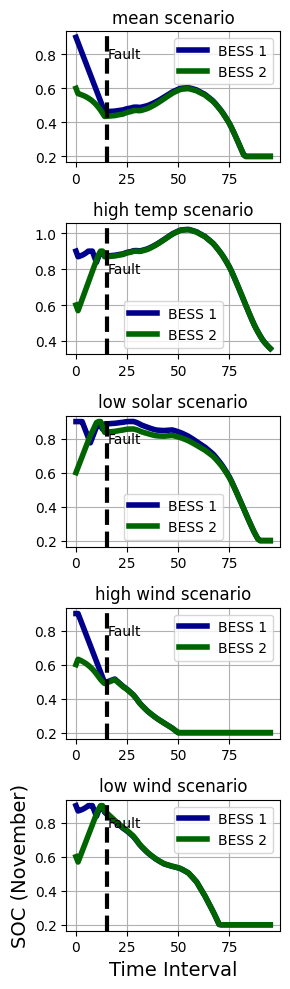

In [6]:
# choose a fault time = isloation time 
while True:
    try:
        isolation_time = int(input("Enter isolation time in hours (0-95): "))
        if 0 <= isolation_time <= 95:
            break
        else:
            print("Invalid input. Please enter a number between 1 and 24.")
    except ValueError:
        print("Invalid input. Please enter a number.") 

Tf = isolation_time

if grid_number == 2:
    load_c = Residential_CL[:, month - 1]
    extended_soc_scenarios = []
    soc_scenarios = np.array(soc_scenarios)
    for scenario_index, scenario in enumerate(df_res):
        Ren_power = scenario
        scenario_SOC_i = np.copy(soc_scenarios[scenario_index][:Tf, :]) 
        next_SOC1 = scenario_SOC_i[-1, 0]
        next_SOC2 = scenario_SOC_i[-1, 1]
        a = (next_SOC1 / next_SOC2) ** n
        reached_min_soc = False
        
        for i in range(Tf, 96):
            P_b = Ren_power[i] - load_c[i] 
            if P_b>=0:
                next_SOC1 = scenario_SOC_i[-1, 0] + (((P_b/(1+a)) * Dt * 1000) / (V_DC_res * C_res))
                next_SOC2 = scenario_SOC_i[-1, 1] + (((P_b * a/(1+a)) * Dt * 1000) / (V_DC_res * C_res))
            else:
                next_SOC1 = scenario_SOC_i[-1, 0] + (((P_b * a/(1+a)) * Dt * 1000) / (V_DC_res * C_res))
                next_SOC2 = scenario_SOC_i[-1, 1] + (((P_b/(1+a)) * Dt * 1000) / (V_DC_res * C_res))

            if next_SOC1 <= 0.2 and not reached_min_soc:
                next_SOC1 = 0.2
                reached_min_soc = True          
            elif reached_min_soc:
                next_SOC1 = 0.2  # Set SOC to 0.2 for the remaining time steps
                    
            if next_SOC2 <= 0.2 and not reached_min_soc:
                next_SOC2 = 0.2
                reached_min_soc = True 
            elif reached_min_soc:
                next_SOC2 = 0.2  # Set SOC to 0.2 for the remaining time steps

            a = (next_SOC1 / next_SOC2) ** n
            
            scenario_SOC_i = np.vstack((scenario_SOC_i, [next_SOC1, next_SOC2]))

        extended_soc_scenarios.append(scenario_SOC_i)
        
    # Create a figure with 5 subplots
    fig, axs = plt.subplots(5, 1, figsize=(3, 10))  # Create 5 subplots (one for each scenario)
    colors = ['darkblue', 'darkgreen']
    labels = ['BESS 1', 'BESS 2']

    for i, (soc, label_res_i) in enumerate(zip(extended_soc_scenarios, label_res)):
        axs[i].plot(soc[:, 0], label=labels[0], color=colors[0], linewidth=4)
        axs[i].plot(soc[:, 1], label=labels[1], color=colors[1], linewidth=4)
        axs[i].set_title(f'{label_res_i}')
        axs[i].grid(True)
        axs[i].legend()
        
        axs[i].axvline(x=Tf, color='black', linestyle='--', linewidth=3)
        axs[i].text(Tf + 0.5, 0.8, 'Fault', color='black', fontsize=10, verticalalignment='center')
    
    plt.xlabel('Time Interval', fontsize=14)
    plt.ylabel('SOC (November)', fontsize=14)
    plt.tight_layout()
    #plt.savefig('soc_Nov_Tf10.png', dpi=1500)
    plt.show()